# Notebook showing a known-exoplanet yield estimation

This notebook shows how to use some of the newest features in psisim. It uses the upgraded universe.py class to pull confirmed planet data from the Exoplanet Archive. It then filters these planets to find reasonable VFN candidates based on basic properties (within VFN working region, reasonable mass, etc.). Those planets are fed into the updated spectrum.py which uses picaso to generate spectra for them. From there, we generate planet and host spectra and use observation.py to simulate the observation.

Updates to make:
- Make better approximation of planet phase_angle (currently set to 0)
- Perform quick SNR analysis using the analytical equations from Gary's 2018 SPIE paper.

In [ ]:
from psisim import telescope,instrument,observation,spectrum,universe,plots,signal
import numpy as np
import time
import os
from importlib import reload
import speclite.filters
import copy
import astropy.units as u
from astropy.table import QTable, Table, Column
import matplotlib.pylab as plt
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter
import importlib
import warnings

SMALL_SIZE = 32
MEDIUM_SIZE = 40
BIGGER_SIZE = 48

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 5
#plt.rc('text', usetex=True)

## Telescope and instrument setup

In [ ]:
#Setup the path to the peripheral files
path = '/scr3/dmawet/ETC/'
#Load the filter objects from speclite
filters = spectrum.load_filters()

In [ ]:
#-- Telescope Setup
# Contains telescope params, site characteristics, and current conditions
keck = telescope.Keck(path=path)
keck.airmass=1.1
keck.water_vapor=1.6
keck.seeing = keck.median_seeing

In [ ]:
#-- Instrument parameters
exp_time = 600           # [s]
main_filter = 'TwoMASS-K'   # Band for observation
host_filter = 'TwoMASS-K'   # Filter in which star's magnitude will be defined
n_exposures = 60
vort_charge = 1             # Vortex charge for VFN

#-- Simulation parameters
doppler_shift = True   # Decide whether to doppler shift the host spectrum
broaden       = True   # Decide whether to line-broaden the host spectrum
cal           = 0.001  #Telluric calibration accuracy of 0.1%


#Initialize a kpic object and set the current filter
kpic = instrument.kpic_phaseII(telescope=keck)
kpic.set_current_filter(main_filter)

#Get the set of wavelengths based on the current instrument setup
wavelengths = kpic.get_wavelength_range()

# Set the observing mode: Exposure time (per exposure), Number of Exposures,filter name, wavelength array
kpic.set_observing_mode(exp_time,n_exposures,main_filter, wavelengths,mode="vfn",vortex_charge=vort_charge) 

## Create universe from Exoplanet Archive data

Load the universe from archive data

In [ ]:
importlib.reload(universe)
# Filename in which to save raw exoplanet archive table
archive_table_filename = "/scr3/dechever/Archive_Pull20210318.ecsv" 
# Instantiate universe object
uni = universe.ExoArchive_Universe(archive_table_filename)
# Pull and populate the planet table
uni.Load_ExoArchive_Universe(force_new_pull=False)

# Create easy-access table variables
planet_table = uni.planets
full_planet_table = copy.deepcopy(uni.planets)

# Display the table
planet_table

## Select promising targets for modeling

##### First, remove planets missing key parameters needed for picaso

In [ ]:
# Create masks for missing entries by (relevant) column
sma_mask = np.logical_not(np.isnan(planet_table['SMA']))
pms_mask = np.logical_not(np.isnan(planet_table['PlanetMass']))
prd_mask = np.logical_not(np.isnan(planet_table['PlanetRadius']))
plg_mask = np.logical_not(np.isnan(planet_table['PlanetLogg'])) 
  # ignore missing teq values since we deal with them later
ptq_mask = np.full(sma_mask.shape, True) #np.logical_not(np.isnan(planet_table['PlanetTeq']))  
slg_mask = np.logical_not(np.isnan(planet_table['StarLogg'])) 
stf_mask = np.logical_not(np.isnan(planet_table['StarTeff'])) 
srd_mask = np.logical_not(np.isnan(planet_table['StarRad']))

# Addtionally, remove planets missing AngSep and Kmag
  # Not needed by picaso but needed for VFN part of simulations 
  # missing values are rare
ang_mask = np.logical_not(np.isnan(planet_table['AngSep']))
stk_mask = np.logical_not(np.isnan(planet_table['StarKmag']))

# Combine masks
com_mask = sma_mask & pms_mask & prd_mask & plg_mask & ptq_mask & slg_mask & stf_mask & srd_mask & ang_mask & stk_mask
print('Number of planets with sufficient information: %d'%np.sum(com_mask))

planet_table = planet_table[com_mask]

# Display the new table
planet_table

##### Next, downselect based on VFN coupling region

In [ ]:
#Down select the planets whose separations are beyond VFN coupling region
iwa = 0.4*np.median(wavelengths).to(u.m)/keck.diameter*u.rad
owa = 1.4*np.median(wavelengths).to(u.m)/keck.diameter*u.rad

planet_table = planet_table[planet_table['AngSep'] > iwa.to(u.mas)]
planet_table = planet_table[planet_table['AngSep'] < owa.to(u.mas)]

# Display the new table
planet_table

##### Make additional cuts based on mass

In [ ]:
# Make sure we're in the giant planet regime for now
planet_table = planet_table[planet_table['PlanetMass'].to(u.earthMass).value > 130]
# Remove objects above the hydrogen burning limit
planet_table = planet_table[planet_table['PlanetMass'].to(u.earthMass).value < 4200]

# Display the new table
planet_table

##### Since we have so many planet options, let's manually choose some

In [9]:
# OPTION 1: pick planets out by name
'''
st2find = ['HD 86226', 'GJ 3021', 'HD 169830', 'Missing_Planet']
inds = []
for st in st2find:
    try:
        inds.append(np.where(planet_table['StarName'] == st)[0][0])
    except:
        print('Star %s was missing from the table!'%st)
    
planet_table = planet_table[inds]
'''

#OPTION 2: pick random planets
n_plan = 5
rng = np.random.default_rng()
planet_table = planet_table[np.sort(rng.choice(len(planet_table),size=n_plan,replace=False))]

planet_table

PlanetName,StarName,SMA,Ecc,Inc,PlanetMass,PlanetRadius,PlanetTeq,RA,Dec,Distance,StarSpT,StarMass,StarTeff,StarRad,StarLogg,StarLum,StarAge,StarVsini,StarRadialVelocity,StarZ,StarParallax,StarBMag,StarVmag,StarRmag,StarImag,StarJmag,StarHmag,StarKmag,DiscoveryMethod,Flux Ratio,ProjAU,Phase,AngSep,PlanetLogg
,,AU,,deg,earthMass,earthRad,K,deg,deg,pc,,solMass,K,solRad,dex(cm / s2),solLum,Gyr,km / s,km / s,,mas,,,,,,,,,,AU,rad,mas,dex(cm / s2)
object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,float64,float64,float64,float64
HD 60532 b,HD 60532,0.77,0.26,nan,336.8998,13.8,nan,113.5130656,-22.2958661,25.9716,F6 IV,1.5,6245.0,2.57,3.8,10.023052380778994,2.8,8.0,60.7,-0.26,38.4773,4.932,4.44,nan,3.83,3.703,3.318,3.355,Radial Velocity,nan,nan,nan,29.647769101634093,3.238897662321307
HD 13908 c,HD 13908,2.03,0.12,nan,1630.4,12.8,nan,34.5609102,65.5941901,79.5515,F8 V,1.29,6255.0,1.67,4.11,3.9994474976109746,2.9,4.2,15.88,0.01,12.5417,8.042,7.52,nan,nan,6.497,6.251,6.21,Radial Velocity,nan,nan,nan,25.518060627392313,3.9890293093273868
mu Leo b,mu Leo,1.1,0.09,nan,762.8,13.3,nan,148.1898673,26.0067142,32.6081,K2 III,1.5,4538.2,11.4,2.4,62.66138646723353,3.35,2.4,13.6,0.36,30.6493,5.121,3.86648,nan,nan,1.974,1.327,1.364,Radial Velocity,nan,nan,nan,33.733949540144934,3.6258624844005687
HD 148156 b,HD 148156,2.45,0.52,nan,270.144,13.9,nan,247.0723035,-46.3175085,57.1289,G0/2 V,1.22,6308.0,1.21,4.56,1.7782794100389228,nan,5.73,-1.84,0.29,17.4755,8.257,7.69,nan,nan,6.688,6.489,6.397,Radial Velocity,nan,nan,nan,42.885474777214334,3.1367208075908777
HD 187085 b,HD 187085,2.1,0.251,nan,265.70588,13.9,nan,297.3915731,-37.7809929,45.8993,G0 V,1.19,6117.0,1.27,4.28,134.89628825916532,2.747,5.1,15.38,0.12,21.758,7.674,7.22,nan,nan,6.19,5.951,5.876,Radial Velocity,nan,nan,nan,45.75233173490663,3.1295266467898357


## Create a table copy that has values rounded/approximated/formatted for psisim

In [ ]:
# First, make a copy of the table with the actual values
planet_table_raw = copy.deepcopy(planet_table)

In [11]:
#-- Define the grids that phoenix models like
# Options for the star properties
host_temp_list=np.hstack([np.arange(2300,7000,100),np.arange(7000,12200,200)])
host_logg_list=[6.00,5.50,5.00,4.50,4.00,3.50,3.00,2.50,2.00,1.50,1.00,0.50]
host_Z_list = np.array([-4.0,-3.0,-2.0,-1.5,-1.0,-0.5,-0.0,+0.5,+1.0])
# Create valid grids
    # use 'extrapolate' for some grids to push out of range values to be within range
f_teff_grid=interp1d(host_temp_list,host_temp_list,kind='nearest',bounds_error=False,fill_value='extrapolate')
f_logg_grid=interp1d(host_logg_list,host_logg_list,kind='nearest',bounds_error=False,fill_value='extrapolate')
    # Set Z to nan since the try: except: in spectrum.py will deal with this
f_Z_grid   =interp1d(host_Z_list,host_Z_list,kind='nearest',bounds_error=False,fill_value=np.nan)

#-- Push star values towards requisite for models
# Set Teff and Logg to be within the requisite grids
planet_table['StarTeff'] = f_teff_grid(planet_table['StarTeff']) *planet_table['StarTeff'].unit
planet_table['StarLogg'] = f_logg_grid(planet_table['StarLogg']) *planet_table['StarLogg'].unit
#     # Round metalicity to valid range and cast to phoenix-supported strings
#     z_mask = np.logical_not(np.isnan(planet_table['StarZ']))  # mask for non-nan values since interp1d doesn't work on nan's
#     planet_table['StarZ'][z_mask] = f_Z_grid(planet_table['StarZ'][z_mask]) # interp on non-nan values
#     planet_table['StarZ'] = planet_table['StarZ'].astype(str)
#     planet_table['StarZ'][planet_table['StarZ']=='nan'] = '?'
# For now, set metalicity to -0.0 so that our phoenix models match the picaso assumption of 0.0122
  # This is because jason recommends using the picaso default of 0.0122 for all stars for now
planet_table['StarZ'] = np.full((len(planet_table),),'-0.0')
# Set some constant alpha and limb darkening values for now
planet_table['StarAlpha'] = np.full((len(planet_table),),'0.0')
planet_table['StarLimbDarkening'] = np.ones((len(planet_table),))*0.2
# Provide default values for nans
planet_table['StarRadialVelocity'][np.isnan(planet_table['StarRadialVelocity'])] = 0.0 *planet_table['StarRadialVelocity'].unit
  # Can't set to 0.0 since for vsini since rotationally_broaden() call will fail in spectrum.py
planet_table['StarVsini'][np.isnan(planet_table['StarVsini'])] = 0.001 *planet_table['StarVsini'].unit

#-- Get star angular diameter (using small angle approx)
planet_table['StarAngDiam'] = ((2*planet_table['StarRad']/planet_table['Distance']).decompose()*u.rad).to(u.mas)

#-- Create empty column for ao-mag so we can populate it later
planet_table['StarAOmag'] = np.full((len(planet_table),), np.nan)

#-- Estimate planet Teq when missing
planet_teq = ((planet_table['StarRad']/planet_table['SMA']).decompose()**2 * planet_table['StarTeff'].value**4)**(1./4) *u.K
ptq_mask = np.isnan(planet_table['PlanetTeq'])
planet_table['PlanetTeq'][ptq_mask] = planet_teq[ptq_mask] 


#-- For now: set phase=0 for all planets. TODO: we should find a better way to decide on a planet phase
planet_table['Phase'][:] = 0.0 *u.rad

planet_table

PlanetName,StarName,SMA,Ecc,Inc,PlanetMass,PlanetRadius,PlanetTeq,RA,Dec,Distance,StarSpT,StarMass,StarTeff,StarRad,StarLogg,StarLum,StarAge,StarVsini,StarRadialVelocity,StarZ,StarParallax,StarBMag,StarVmag,StarRmag,StarImag,StarJmag,StarHmag,StarKmag,DiscoveryMethod,Flux Ratio,ProjAU,Phase,AngSep,PlanetLogg,StarAlpha,StarLimbDarkening,StarAngDiam,StarAOmag
,,AU,,deg,earthMass,earthRad,K,deg,deg,pc,,solMass,K,solRad,dex(cm / s2),solLum,Gyr,km / s,km / s,,mas,,,,,,,,,,AU,rad,mas,dex(cm / s2),,,mas,
object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,str4,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,float64,float64,float64,float64,str3,float64,float64,float64
HD 60532 b,HD 60532,0.77,0.26,nan,336.8998,13.8,772.4336487154548,113.5130656,-22.2958661,25.9716,F6 IV,1.5,6200.0,2.57,4.0,10.023052380778994,2.8,8.0,60.7,-0.0,38.4773,4.932,4.44,nan,3.83,3.703,3.318,3.355,Radial Velocity,nan,nan,0.0,29.647769101634093,3.238897662321307,0.0,0.2,0.9203669285429271,nan
HD 13908 c,HD 13908,2.03,0.12,nan,1630.4,12.8,389.67187543883097,34.5609102,65.5941901,79.5515,F8 V,1.29,6300.0,1.67,4.0,3.9994474976109746,2.9,4.2,15.88,-0.0,12.5417,8.042,7.52,nan,nan,6.497,6.251,6.21,Radial Velocity,nan,nan,0.0,25.518060627392313,3.9890293093273868,0.0,0.2,0.1952516376386819,nan
mu Leo b,mu Leo,1.1,0.09,nan,762.8,13.3,987.9088875881005,148.1898673,26.0067142,32.6081,K2 III,1.5,4500.0,11.4,2.5,62.66138646723353,3.35,2.4,13.6,-0.0,30.6493,5.121,3.86648,nan,nan,1.974,1.327,1.364,Radial Velocity,nan,nan,0.0,33.733949540144934,3.6258624844005687,0.0,0.2,3.2516661059656093,nan
HD 148156 b,HD 148156,2.45,0.52,nan,270.144,13.9,301.92459199174255,247.0723035,-46.3175085,57.1289,G0/2 V,1.22,6300.0,1.21,4.5,1.7782794100389228,nan,5.73,-1.84,-0.0,17.4755,8.257,7.69,nan,nan,6.688,6.489,6.397,Radial Velocity,nan,nan,0.0,42.885474777214334,3.1367208075908777,0.0,0.2,0.19699540462932802,nan
HD 187085 b,HD 187085,2.1,0.251,nan,265.70588,13.9,323.4970642474507,297.3915731,-37.7809929,45.8993,G0 V,1.19,6100.0,1.27,4.5,134.89628825916532,2.747,5.1,15.38,-0.0,21.758,7.674,7.22,nan,nan,6.19,5.951,5.876,Radial Velocity,nan,nan,0.0,45.75233173490663,3.1295266467898357,0.0,0.2,0.257350043308806,nan


##### NOTE: an intermediate spectrum is not necessary for this particular simulation since we are checking detectability and Jason's high-res opacity files already have a very similar resolution to KPIC

## Define function to generate planet spectrum

This gets the opacity file and uses our spectrum.py functions to get the picaso spectrum

In [ ]:
# Define opacity file to load
opacity_folder = os.path.join(os.getenv("picaso_refdata"),'opacities')
dbname = 'Natasha Batalha - opacity_K.db'
dbname = os.path.join(opacity_folder,dbname)
# Define wavelength range for opacity file
  # Not required but will reduce picaso runtime since not simulating unused wavelengths
  # Set slightly larger than requested wvs due to apparent picaso internal rounding on wave_range
  # such that going beyond range isn't an issue
wvrng = [wavelengths.min().value*0.98, wavelengths.max().value*1.02]

# Load opacity file
opacity = spectrum.load_picaso_opacity(dbname=dbname,wave_range=wvrng)

# Function that actually does the simulation
def generate_spectrum(planet):
    """
    Function to loop over to generate spectra.
    """
    # For now, we'll assume user has filtered planet table so that 
    #  all planets are gas giants. This is because the psisim picaso
    #  implementation is limited to gas giants for now
    planet_type = "Gas"
    
    # Generate spectrum
    time1 = time.time()
    atmospheric_parameters = spectrum.generate_picaso_inputs(planet,planet_type,opacity,clouds=True,planet_teq=planet['PlanetTeq'].value)
    fpfs_ref, fp_therm, df = spectrum.simulate_spectrum(planet,wavelengths,kpic.current_R,atmospheric_parameters)
    print('Spectrum took {0:.3f} s'.format(time.time()-time1))
    
    return fpfs_ref, fp_therm, df

## Define function to get host spectrum and normalize picaso spectrum

##### The thermal spectrum needs to be in contrast units for psisim; let's compute it as such

We'll define a function that pulls out the pertinent stellar properties, gets the raw phoenix specrtrum, and normalizes the picaso spectrum by it correctly

It'll also automatically compute the full host spectrum that psisim will use later (since we already have everything we need for it here)

In [ ]:
def picaso2contrast(planet,fp_thermal):
    
    # setup the user params that a Phoenix model needs: (path, object_filter, magn_in_object_filter,
    # filters_object,current_filter). 
    host_user_params = (path,host_filter,planet['StarKmag'],filters,kpic.current_filter)
    
    #-- Get the full host spectrum as usual
    host_spectrum = spectrum.get_stellar_spectrum(planet,wavelengths,kpic.current_R,model="Phoenix",
                                              user_params=host_user_params,doppler_shift=doppler_shift,broaden=broaden,
                                              delta_wv=kpic.current_dwvs)

    #-- Now get the host spectrum without any scaling or anything so we can use it to normalize the picaso spec
    #Repeat the checks done in get_stellar_spectrum()
    try: 
        host_z = planet['StarZ']
    except Exception as e: 
        print(e)
        print("Some error in reading your star Z value, setting Z to zero")
        host_z = '-0.0'
    try: 
        host_alpha = planet['StarAlpha']
    except Exception as e:
        print(e)
        print("Some error in reading your star alpha value, setting alpha to zero")
        host_alpha ='0.0'

    #Read in the model spectrum        
    wave_u,spec_u = spectrum.get_phoenix_spectrum(planet['StarLogg'].to(u.dex(u.cm/ u.s**2)).value,
                    planet['StarTeff'].to(u.K).value,host_z,host_alpha,path=path)

    #Get the wavelength sampling of the stellar spectrum
    dwvs_u = wave_u - np.roll(wave_u, 1)
    dwvs_u[0] = dwvs_u[1]
    mean_R_in = np.mean(wave_u/dwvs_u)

    if kpic.current_R < mean_R_in:
        ds = spectrum.downsample_spectrum(spec_u,mean_R_in,kpic.current_R)
    else:
        wargnings.warn("Your requested Resolving power is greater than or equal to the native model. We're not upsampling here, but we should.")
        ds = spec_u

    stellar_spectrum = np.interp(wavelengths,wave_u,ds) *spec_u.unit
    
    ## Apply a doppler shift if you'd like.
    if doppler_shift:
        # NOTE: I removed some checks done here since earlier in the script we guaranteed everything we need is present 
        stellar_spectrum = spectrum.apply_doppler_shift(wavelengths,stellar_spectrum,kpic.current_dwvs,planet['StarRadialVelocity'].to(u.km/u.s).value)
        
    ## Rotationally broaden if you'd like
    if broaden:
        # NOTE: I removed some checks done here since earlier in the script we guaranteed everything we need is present 
        stellar_spectrum = spectrum.rotationally_broaden(wavelengths,stellar_spectrum,planet['StarLimbDarkening'],planet['StarVsini'])
            
    # Convert spectrum to ergs/s/cm3 as needed for normalization with picaso planet spectrum
    stellar_spectrum = stellar_spectrum.to(u.erg/u.s/u.cm**2/u.cm,equivalencies=u.spectral_density(wavelengths))
    fp_thermal = fp_thermal.to(u.erg/u.s/u.cm**2/u.cm,equivalencies=u.spectral_density(wavelengths))
    
    # Compute fpfs_thermal as done in picaso
    fpfs_thermal_ours = fp_thermal/(stellar_spectrum)*(planet['PlanetRadius']/planet['StarRad']).decompose()**2
    
    
    #-- Get the StarAOmag (needed later for AO magnitude in observation sim)
    StarAOmag = spectrum.get_model_ABmags(planet,[kpic.ao_filter],model="Phoenix",
                                              verbose=False,user_params=host_user_params)
    
    return fpfs_thermal_ours.value, host_spectrum, StarAOmag

## Define a function to plot the results

In [ ]:
def res_plotter():
    n_plots = 3
    
    fig, (ax1, ax2, ax3) = plt.subplots(n_plots, sharex=True, figsize=(30,10*n_plots))
    fig.set(facecolor='white')
    tit =  "Planet %s\n"%planet['PlanetName']
    tit += "$P_{Teq}$:  %0.f K, $P_{Mass}$: %.2f $M_{J}$, $P_{Rad}$: %.2f $R{_J}$, AngSep: %.1f mas, SMA: %0.2f AU\n"%(\
            planet['PlanetTeq'].value, planet['PlanetMass'].to(u.jupiterMass).value,
            planet['PlanetRadius'].to(u.jupiterRad).value, planet['AngSep'].value,planet['SMA'].value)
    tit += "$S_{Teff}$: %d K, $S_{Mass}$: %.1f $M_{S}$, $S_{Rad}$: %.1f $R_{S}$, $S_{Kmag}$: %0.1f, Dist: %.0f pc, Age: %.2f Gyr"%(\
            planet['StarTeff'].value, planet['StarMass'].value, planet['StarRad'].value, 
            planet['StarKmag'], planet['Distance'].value, planet['StarAge'].value)
    fig.suptitle(tit, y=0.75)    
    fig.subplots_adjust(top=0.65)
    
    ax1.plot(wavelengths,host_spec)
    ax1.axvline(x=wavelengths[wv_min_ind].value,c="r",linewidth=5)
    ax1.axvline(x=wavelengths[wv_max_ind].value,c="r",linewidth=5)
    #ax1.set_title("Host Spectrum")
    ax1.set(ylabel='Host Spectrum\n[ph / (Ang. s cm2)]') # hardcode units since units as printed by astropy would make fig too tall
    
    ax2.semilogy(wavelengths,fpfs_ref, label='Reflected', linewidth=2, linestyle='-')
    ax2.semilogy(wavelengths,fpfs_therm, label='Thermal', linewidth=2, linestyle=':')
    ax2.semilogy(wavelengths,fpfs_ref+fpfs_therm, label='Combined', linewidth=5, zorder=0)
    ax2.legend()
    ax2.axvline(x=wavelengths[wv_min_ind].value,c="r",linewidth=5)
    ax2.axvline(x=wavelengths[wv_max_ind].value,c="r",linewidth=5)
    #ax2.set_title(r'$\bf{Average\ Flux\ Ratio: %f}$'%planet['Flux Ratio'])
    ax2.set(ylabel='Planet Spectrum\n[contrast]')
    
    ax3.plot(wavelengths,obj_spec/noise_plus_systematics)
    ax3.axvline(x=wavelengths[wv_min_ind].value,c="r",linewidth=5)
    ax3.axvline(x=wavelengths[wv_max_ind].value,c="r",linewidth=5)
    ax3.set_title(r'$\bf{CCF\ SNR:\ %f}$'%ccf_snr.value)
    ax3.set(ylabel='SNR w/ Systematics')
    
    
    plt.xlabel('Wavelengths [{}]'.format(wavelengths.unit))

## Iterate through planets and simulate!!

To keep the for loop cleaner, let's define a function that does all the property printing we want

In [ ]:
def prop_print(planet, planet_raw):
        #####################################################
    ###   PRINT A SUMMARY OF THE PLANET-STAR SYSTEM   ###
    print('              -------')
    print('Planet Name: %s'%planet['PlanetName'])
    print('              -------')
    print('======     Values Used     =========      ')
    #print('**___Planet Propeties___**    ')
    print(' PMass: %7.2f M_J   |  PRad:  %5.2f R_E  |  PTeq:  %8.2f K  |  PLogg:  %5.2f'%(
            planet['PlanetMass'].to(u.jupiterMass).value, planet['PlanetRadius'].to(u.jupiterRad).value,
            planet['PlanetTeq'].value, planet['PlanetLogg'].value))
    print(' SMA:     %5.2f AU    |  AngSep: %5.2f mas'%(planet['SMA'].value,planet['AngSep'].value))
    #print('***___Star Propeties___***    ')
    print(' SMass: %7.2f M_S   |  SRad:  %5.2f R_E  |  STeff: %8.2f K  |  SLogg:  %5.2f'%(
            planet['StarMass'].value,planet['StarRad'].value,planet['StarTeff'].value,planet['StarLogg'].value))
    print(' SAge:    %5.2f Gyr   |  SKmag: %5.2f      |  SRadV: %6.2f km/s |  SVsini:%7.3f'%(
            planet['StarAge'].value,planet['StarKmag'],planet['StarRadialVelocity'].value,planet['StarVsini'].value))
    print(' StarZ: %7s       |  SAlpha: %7s   |  SLimbD:   %3.1f      |  SAngDiam: %7.5f mas'%(
            planet['StarZ'], planet['StarAlpha'], planet['StarLimbDarkening'],planet['StarAngDiam'].value))
    print(' RA:      %6.2f deg  |  Dec:   %6.2f deg |  Dist:  %6.2f pc'%(
            planet['RA'].value, planet['Dec'].value, planet['Distance'].value))
    print()
    print('======     Orig Values     =========      ')
    print('                      |                    |  PTeq:  %8.2f K'%planet_raw['PlanetTeq'].value)
    print('                      |                    |  STeff: %8.2f K  |  SLogg:  %5.2f'%(
            planet_raw['StarTeff'].value, planet_raw['StarLogg'].value))
    print('                      |                    |  SRadV: %6.2f km/s |  SVsini:%6.2f'%(
            planet_raw['StarRadialVelocity'].value, planet_raw['StarVsini'].value))
    print(' StarZ: %7.3f       |                    |'%(planet_raw['StarZ']))
    print()
    #####################################################

##### NOTE: we will iterate over the full planet table below so make sure you've culled the planet_table to be small enough so that this iteration is manageable

##########################################
  STARTING NEW PLANET
              -------
Planet Name: HD 60532 b
              -------
======     Values Used     =========      
 PMass:    1.06 M_J   |  PRad:   1.23 R_E  |  PTeq:    772.43 K  |  PLogg:   3.24
 SMA:      0.77 AU    |  AngSep: 29.65 mas
 SMass:    1.50 M_S   |  SRad:   2.57 R_E  |  STeff:  6200.00 K  |  SLogg:   4.00
 SAge:     2.80 Gyr   |  SKmag:  3.35      |  SRadV:  60.70 km/s |  SVsini:  8.000
 StarZ:    -0.0       |  SAlpha:     0.0   |  SLimbD:   0.2      |  SAngDiam: 0.92037 mas
 RA:      113.51 deg  |  Dec:   -22.30 deg |  Dist:   25.97 pc

======     Orig Values     =========      
                      |                    |  PTeq:       nan K
                      |                    |  STeff:  6245.00 K  |  SLogg:   3.80
                      |                    |  SRadV:  60.70 km/s |  SVsini:  8.00
 StarZ:  -0.260       |                    |

-- Generating Planet spectrum


/home/dechever/Code/psisim/psisim/spectrum.py:159: UserWarning: The requested wavelength range [1.950000, 2.449987] is outside the range selected [1.980010, 2.379990] from the opacity model (/home/dechever/Code/picaso/reference/opacities/Natasha Batalha - opacity_K.db)
  warnings.warn(err)    # TODO: warn for now until we get higher res opacity files
/home/dechever/anaconda3/lib/python3.7/site-packages/picaso-2.1-py3.7.egg/picaso/atmsetup.py:185: UserWarning: Ignoring graphite in input file, not a recognized molecule
  warnings.warn("Ignoring %s in input file, not a recognized molecule" % i, UserWarning)
/home/dechever/anaconda3/lib/python3.7/site-packages/picaso-2.1-py3.7.egg/picaso/atmsetup.py:185: UserWarning: Ignoring lithium(c) in input file, not a recognized molecule
  warnings.warn("Ignoring %s in input file, not a recognized molecule" % i, UserWarning)
/home/dechever/anaconda3/lib/python3.7/site-packages/picaso-2.1-py3.7.egg/picaso/atmsetup.py:185: UserWarning: Ignoring ptid in

Spectrum took 10.622 s
-- Dealing with host spectrum and normalization


/home/dechever/anaconda3/lib/python3.7/site-packages/speclite/filters.py:1461: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  values_no_units = values_no_units[values_slice]
/home/dechever/anaconda3/lib/python3.7/site-packages/astropy-4.2-py3.7-linux-x86_64.egg/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


-- Runing Simulation!
Using combined (reflected+thermal) spectrum for planet
Average Flux Ratio: 7.55e-07


/home/dechever/anaconda3/lib/python3.7/site-packages/astropy-4.2-py3.7-linux-x86_64.egg/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Average Contrast: 0.006680
CCF SNR: 0.162525



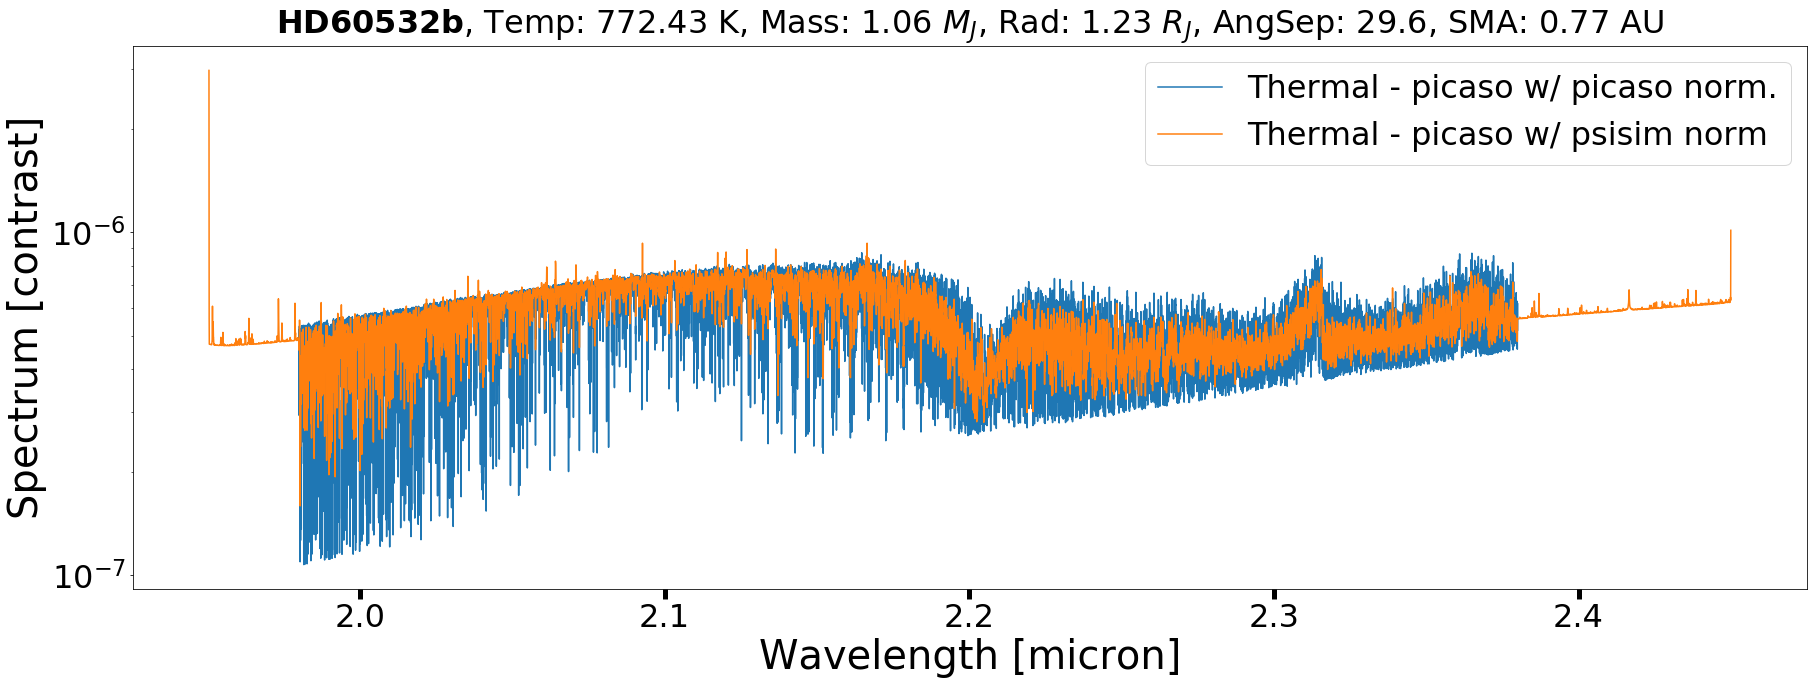

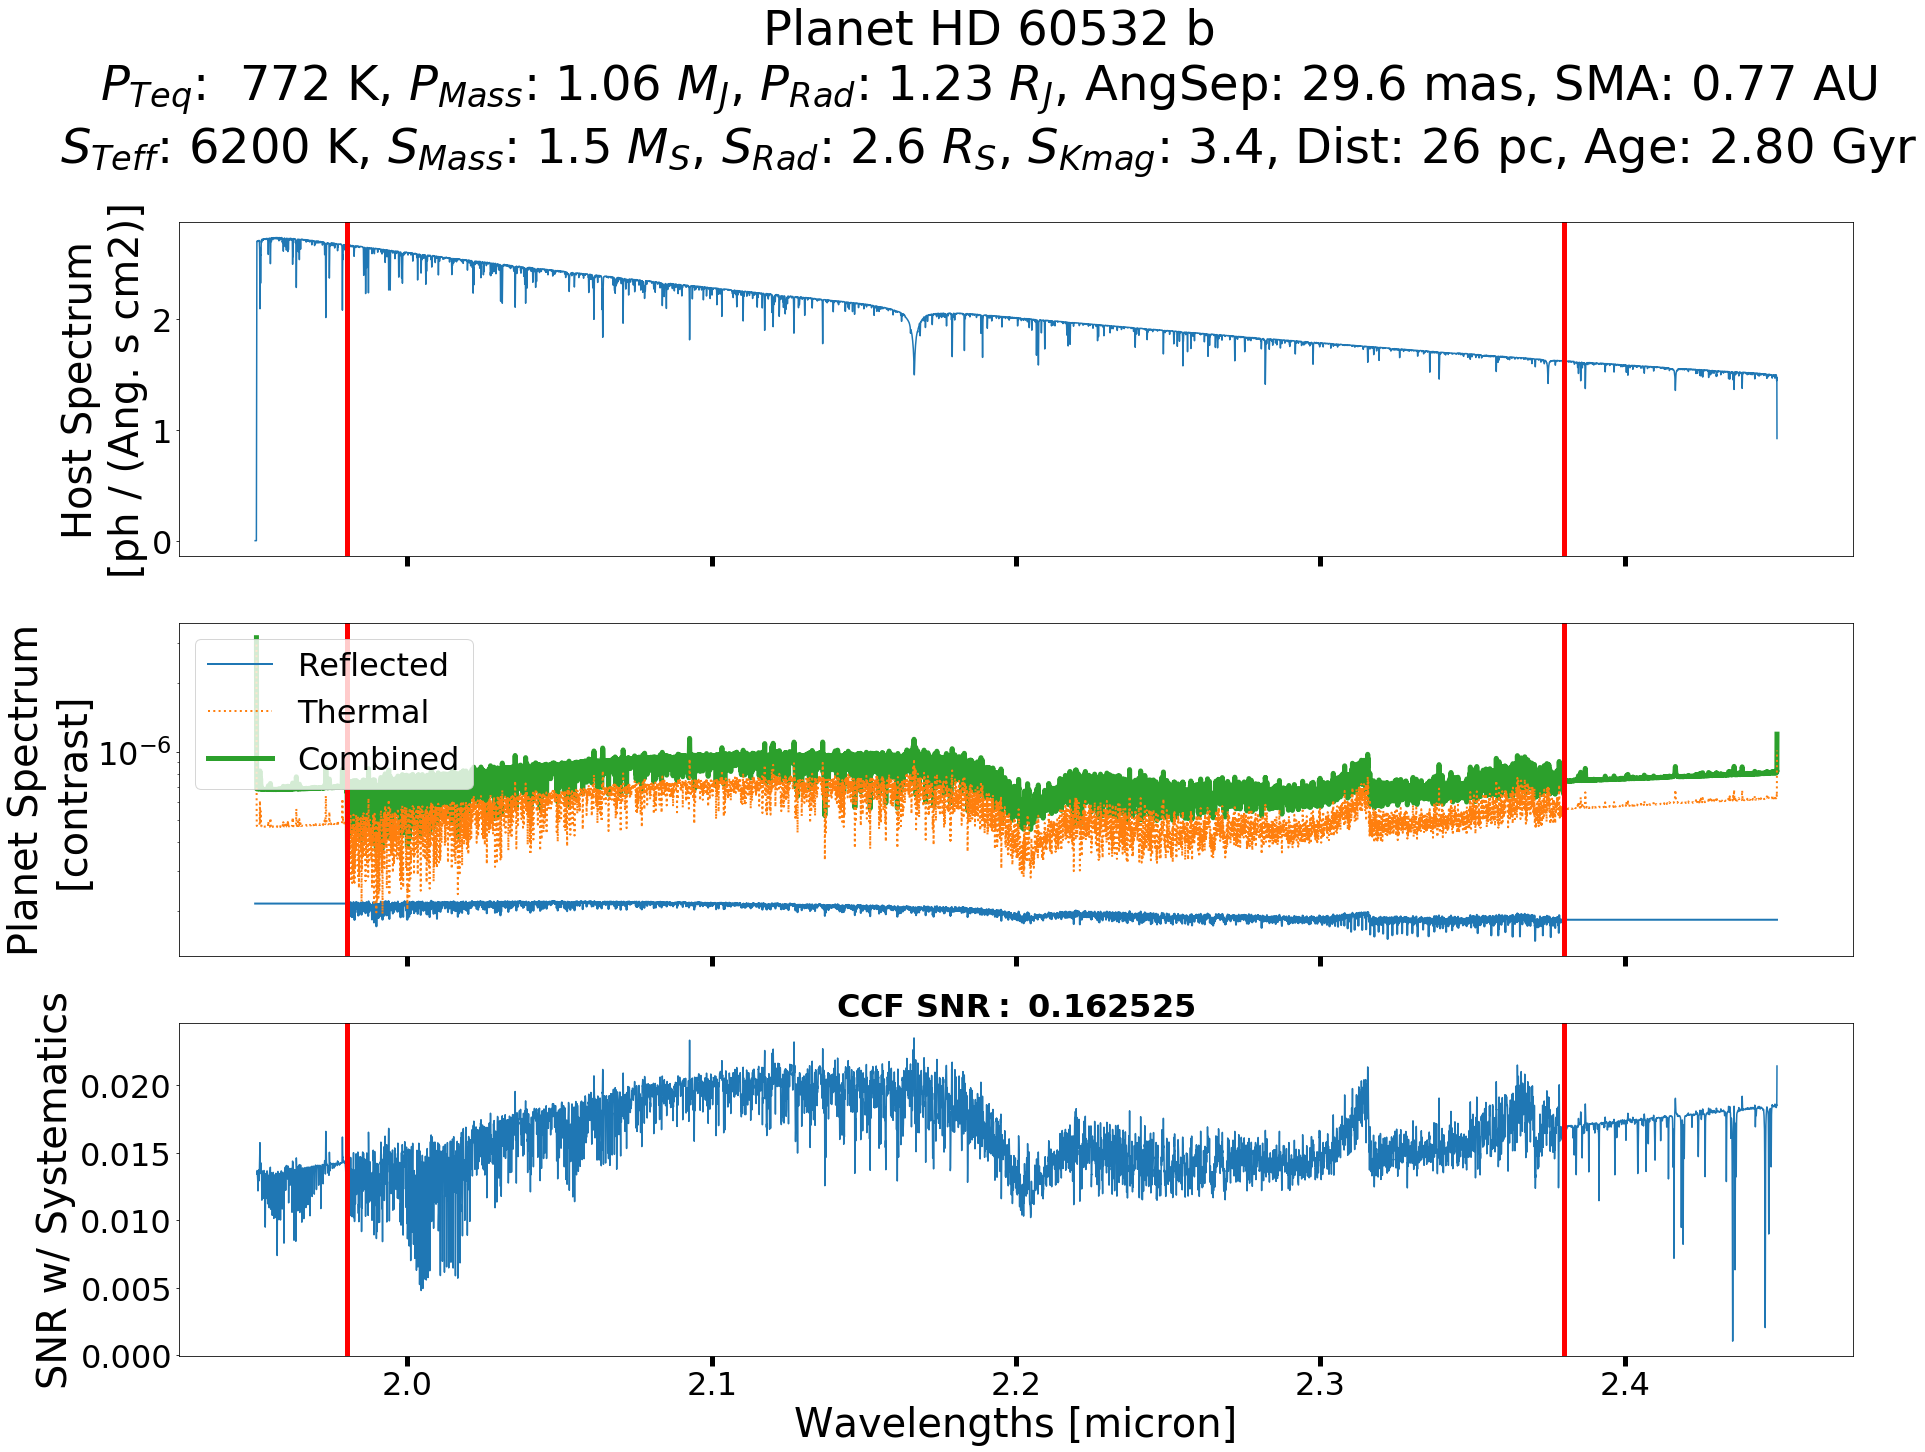

##########################################
  STARTING NEW PLANET
              -------
Planet Name: HD 13908 c
              -------
======     Values Used     =========      
 PMass:    5.13 M_J   |  PRad:   1.14 R_E  |  PTeq:    389.67 K  |  PLogg:   3.99
 SMA:      2.03 AU    |  AngSep: 25.52 mas
 SMass:    1.29 M_S   |  SRad:   1.67 R_E  |  STeff:  6300.00 K  |  SLogg:   4.00
 SAge:     2.90 Gyr   |  SKmag:  6.21      |  SRadV:  15.88 km/s |  SVsini:  4.200
 StarZ:    -0.0       |  SAlpha:     0.0   |  SLimbD:   0.2      |  SAngDiam: 0.19525 mas
 RA:       34.56 deg  |  Dec:    65.59 deg |  Dist:   79.55 pc

======     Orig Values     =========      
                      |                    |  PTeq:       nan K
                      |                    |  STeff:  6255.00 K  |  SLogg:   4.11
                      |                    |  SRadV:  15.88 km/s |  SVsini:  4.20
 StarZ:   0.010       |                    |

-- Generating Planet spectrum
Spectrum took 10.309 s
-- Dealing

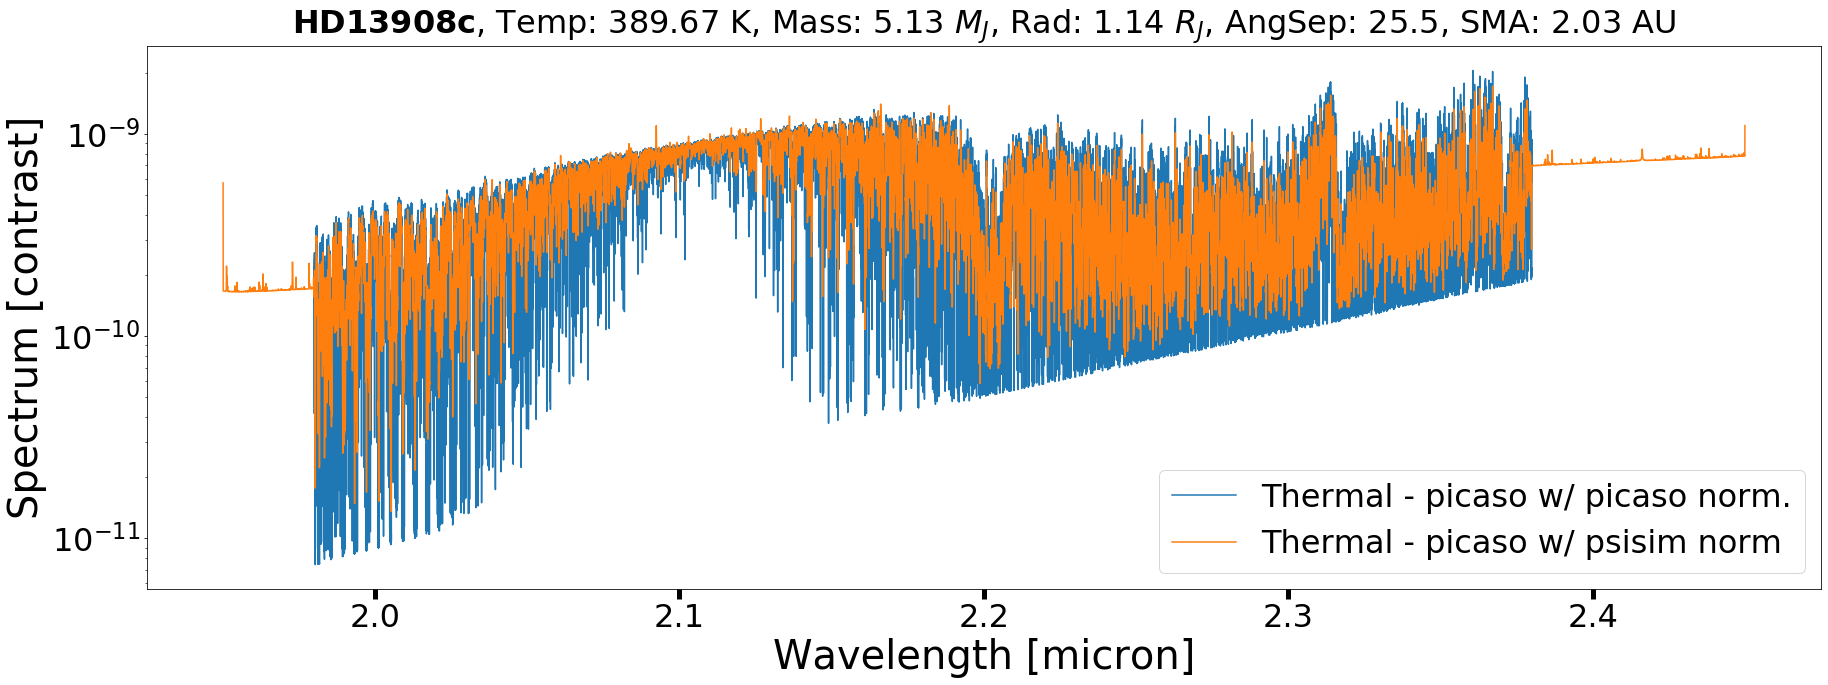

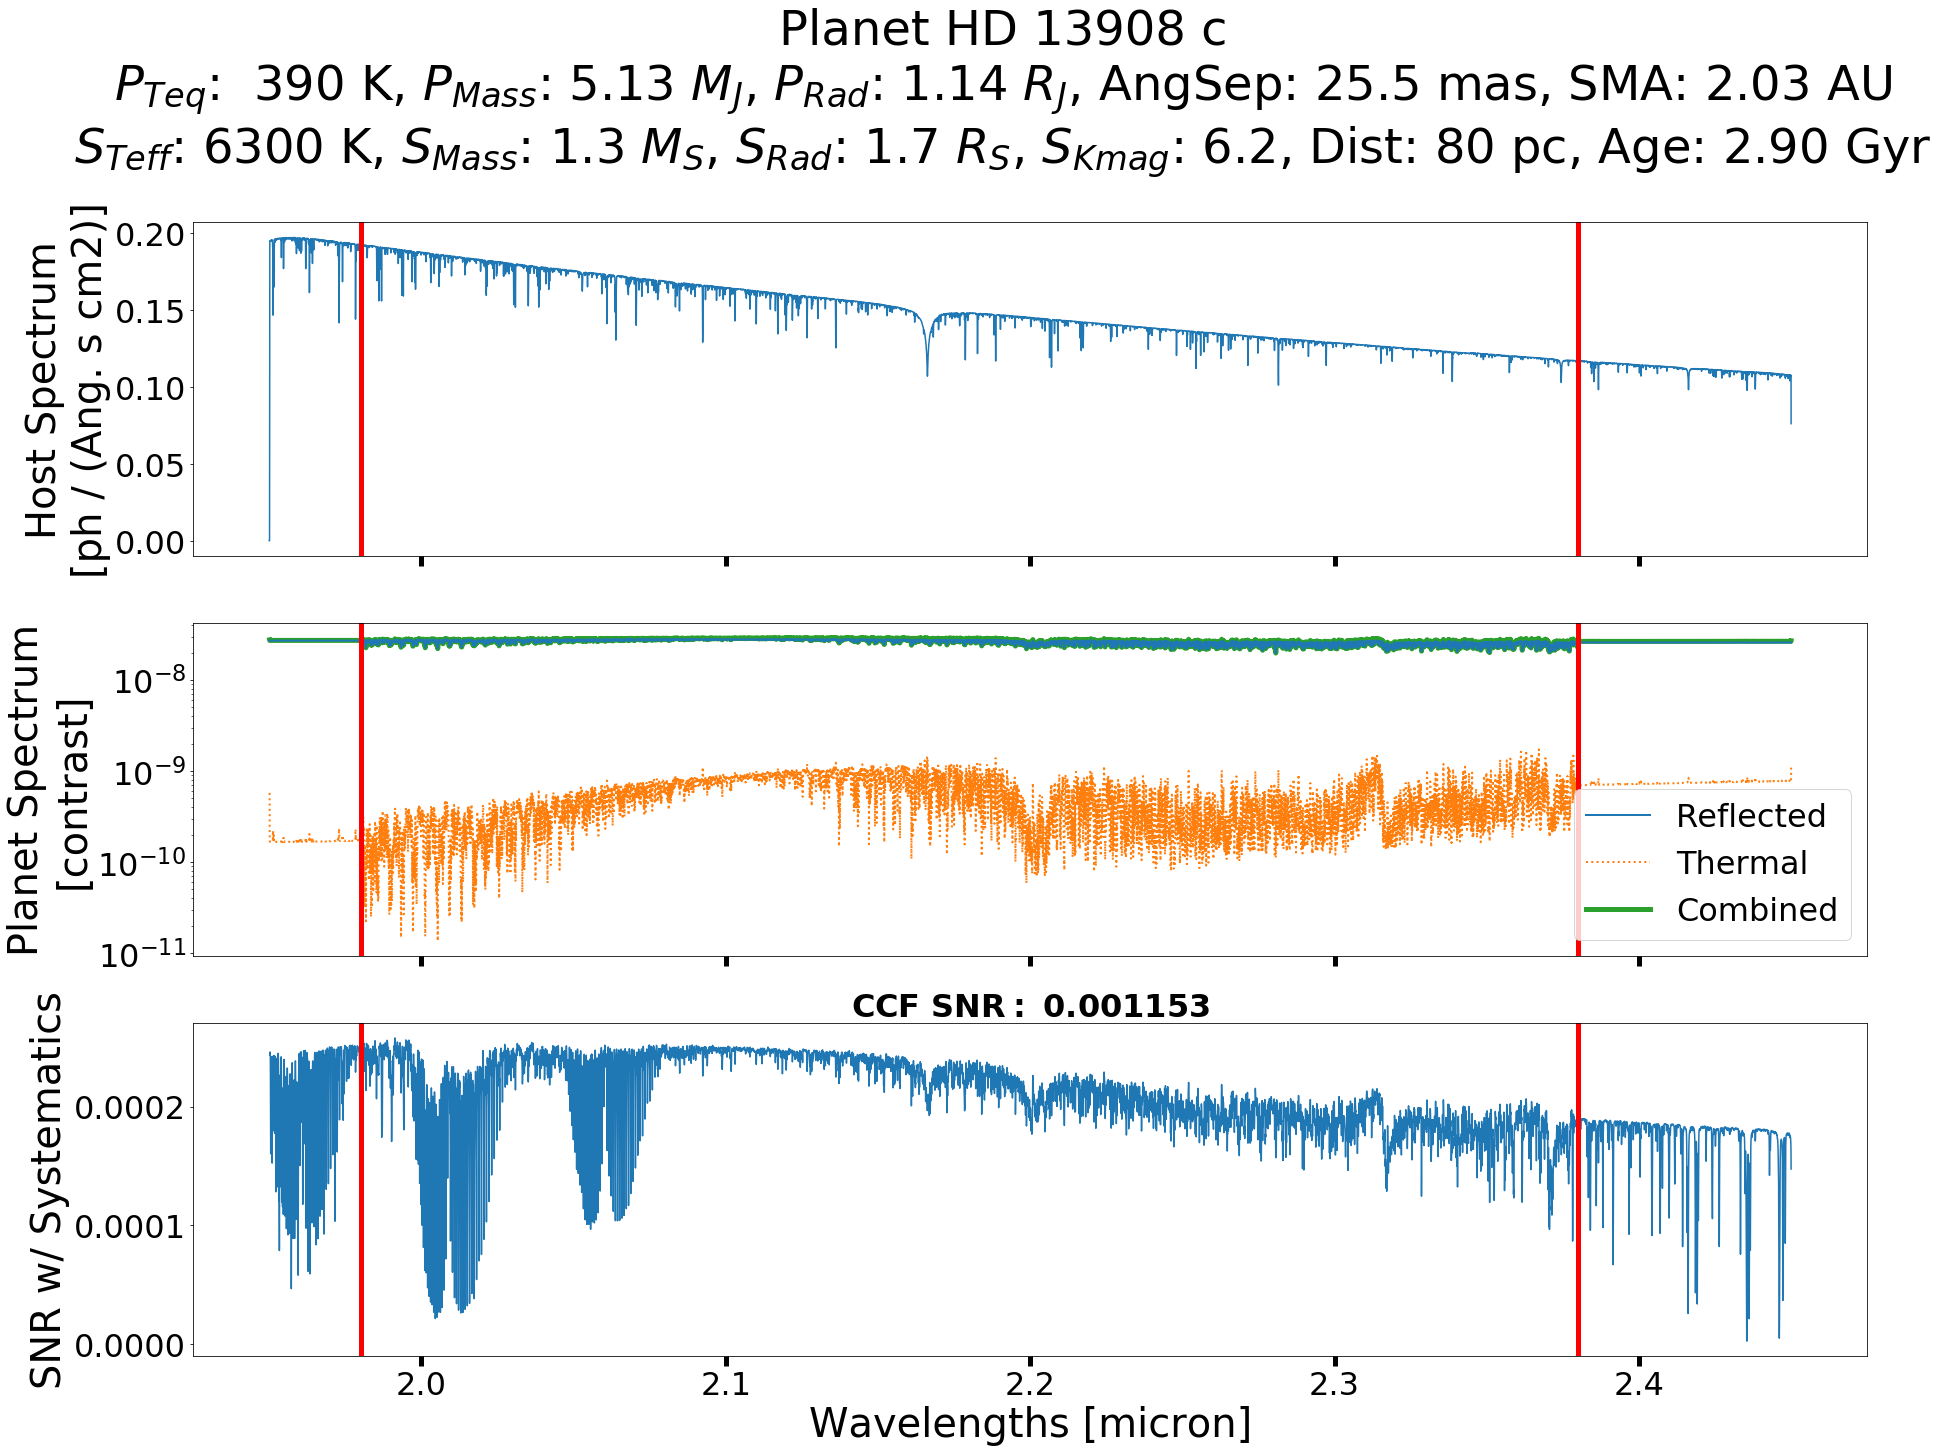

##########################################
  STARTING NEW PLANET
              -------
Planet Name: mu Leo b
              -------
======     Values Used     =========      
 PMass:    2.40 M_J   |  PRad:   1.19 R_E  |  PTeq:    987.91 K  |  PLogg:   3.63
 SMA:      1.10 AU    |  AngSep: 33.73 mas
 SMass:    1.50 M_S   |  SRad:  11.40 R_E  |  STeff:  4500.00 K  |  SLogg:   2.50
 SAge:     3.35 Gyr   |  SKmag:  1.36      |  SRadV:  13.60 km/s |  SVsini:  2.400
 StarZ:    -0.0       |  SAlpha:     0.0   |  SLimbD:   0.2      |  SAngDiam: 3.25167 mas
 RA:      148.19 deg  |  Dec:    26.01 deg |  Dist:   32.61 pc

======     Orig Values     =========      
                      |                    |  PTeq:       nan K
                      |                    |  STeff:  4538.20 K  |  SLogg:   2.40
                      |                    |  SRadV:  13.60 km/s |  SVsini:  2.40
 StarZ:   0.360       |                    |

-- Generating Planet spectrum
Spectrum took 8.257 s
-- Dealing wi

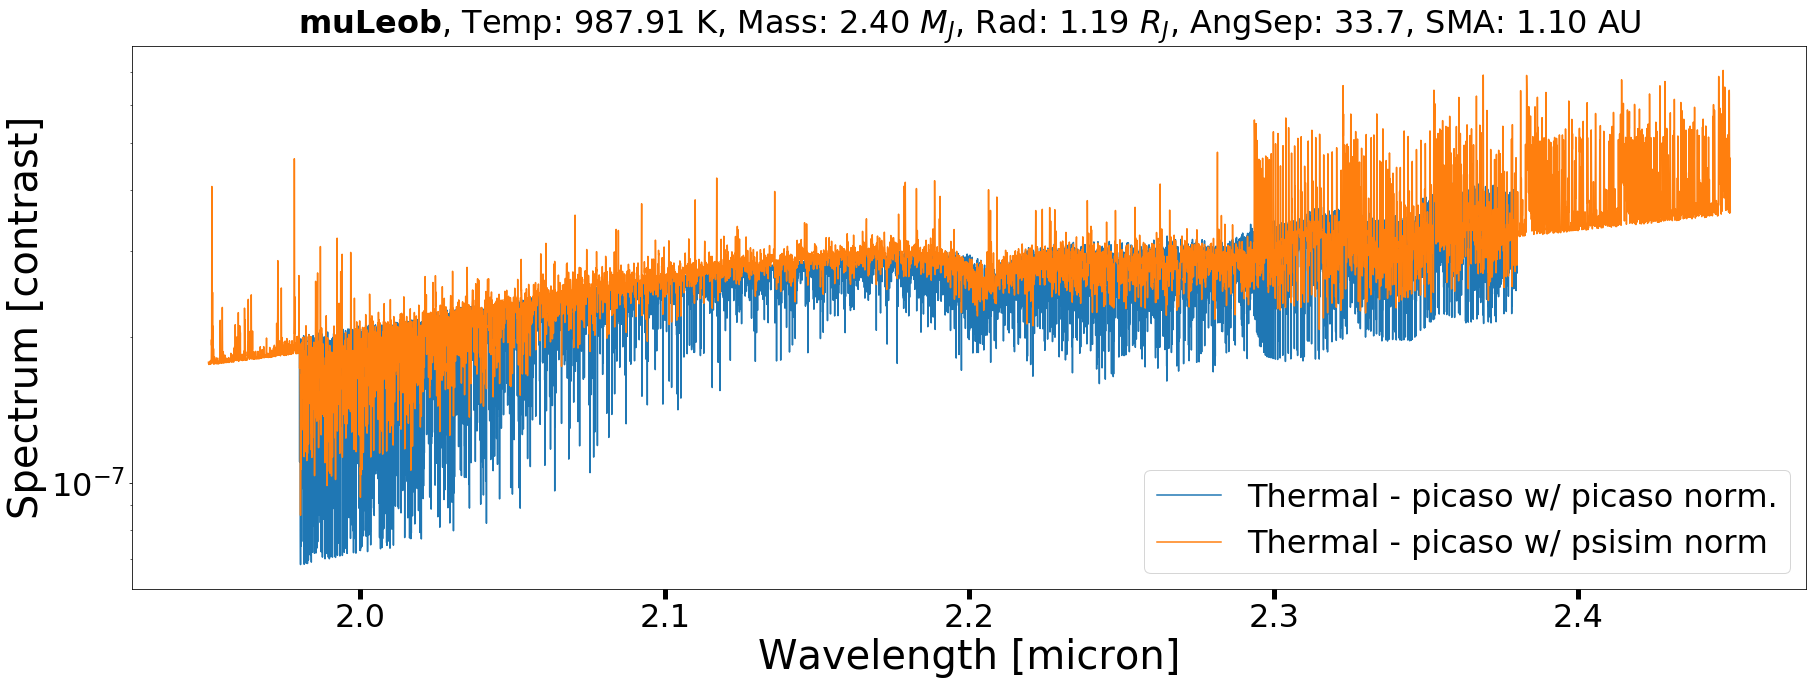

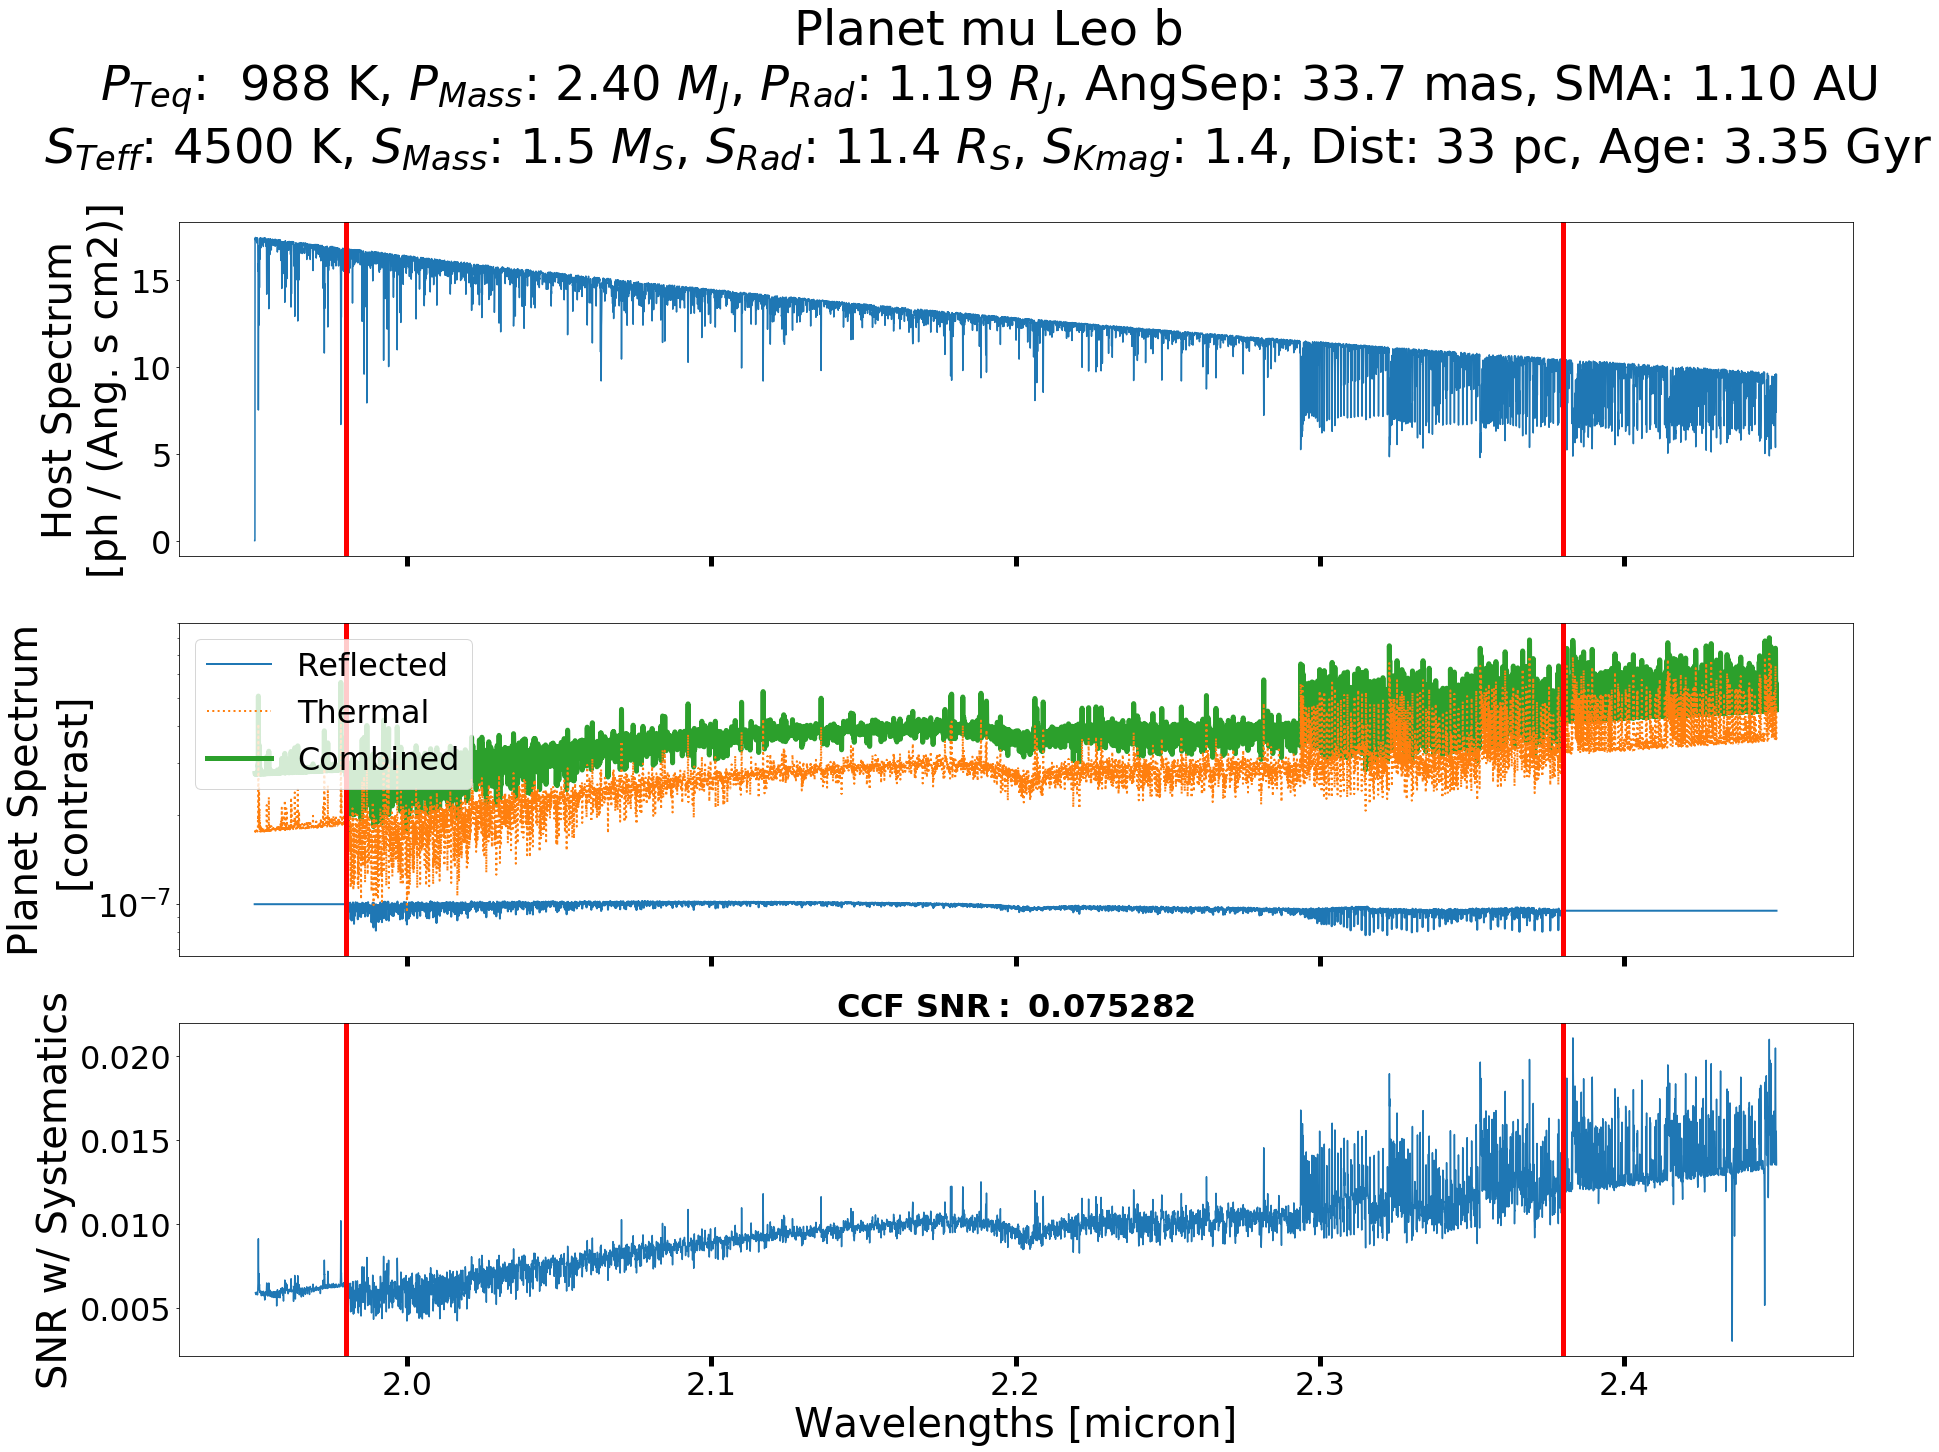

##########################################
  STARTING NEW PLANET
              -------
Planet Name: HD 148156 b
              -------
======     Values Used     =========      
 PMass:    0.85 M_J   |  PRad:   1.24 R_E  |  PTeq:    301.92 K  |  PLogg:   3.14
 SMA:      2.45 AU    |  AngSep: 42.89 mas
 SMass:    1.22 M_S   |  SRad:   1.21 R_E  |  STeff:  6300.00 K  |  SLogg:   4.50
 SAge:      nan Gyr   |  SKmag:  6.40      |  SRadV:  -1.84 km/s |  SVsini:  5.730
 StarZ:    -0.0       |  SAlpha:     0.0   |  SLimbD:   0.2      |  SAngDiam: 0.19700 mas
 RA:      247.07 deg  |  Dec:   -46.32 deg |  Dist:   57.13 pc

======     Orig Values     =========      
                      |                    |  PTeq:       nan K
                      |                    |  STeff:  6308.00 K  |  SLogg:   4.56
                      |                    |  SRadV:  -1.84 km/s |  SVsini:  5.73
 StarZ:   0.290       |                    |

-- Generating Planet spectrum
Spectrum took 7.568 s
-- Dealing

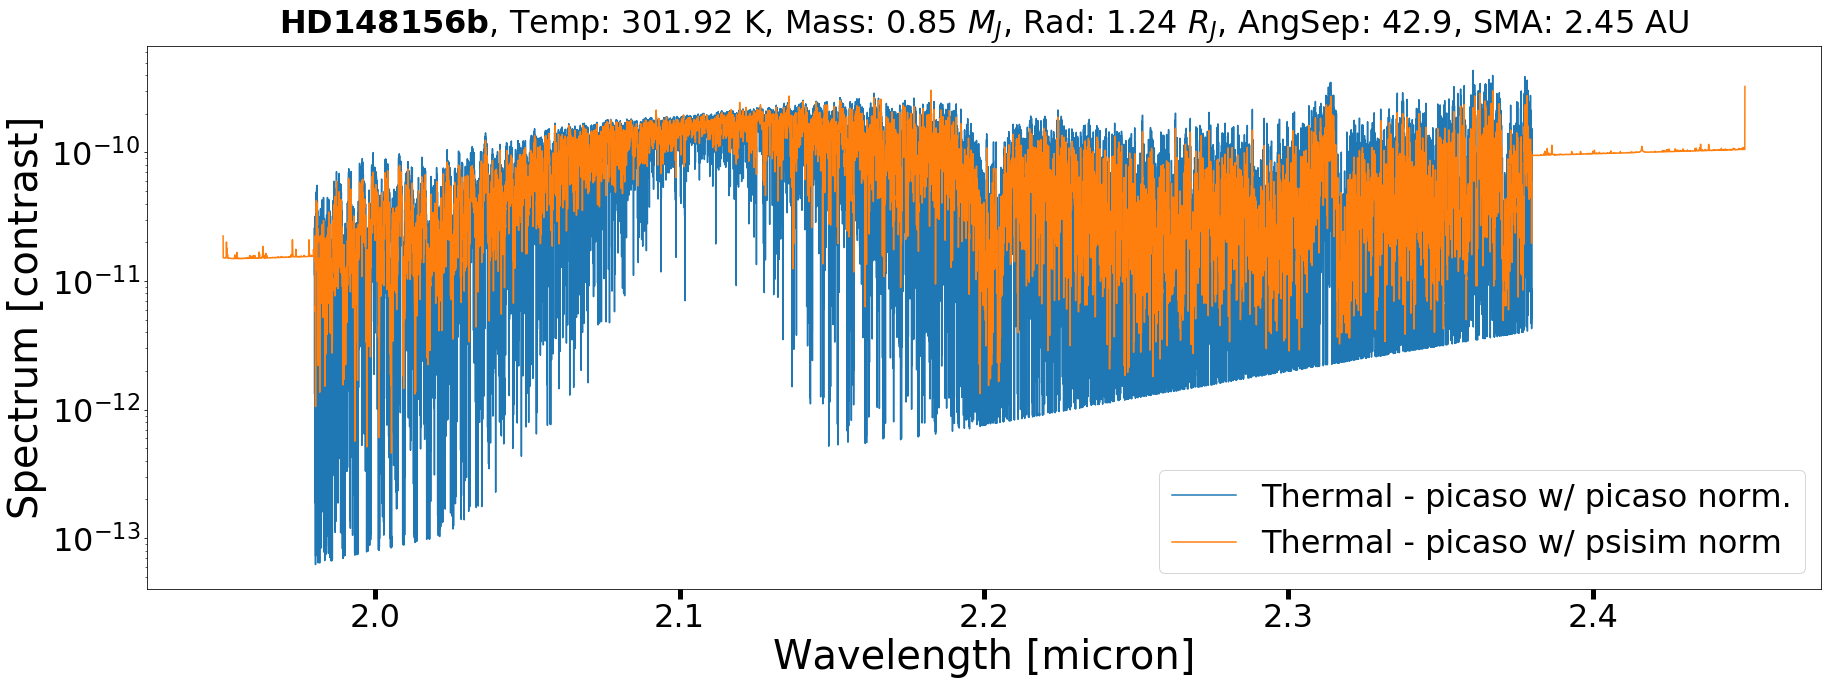

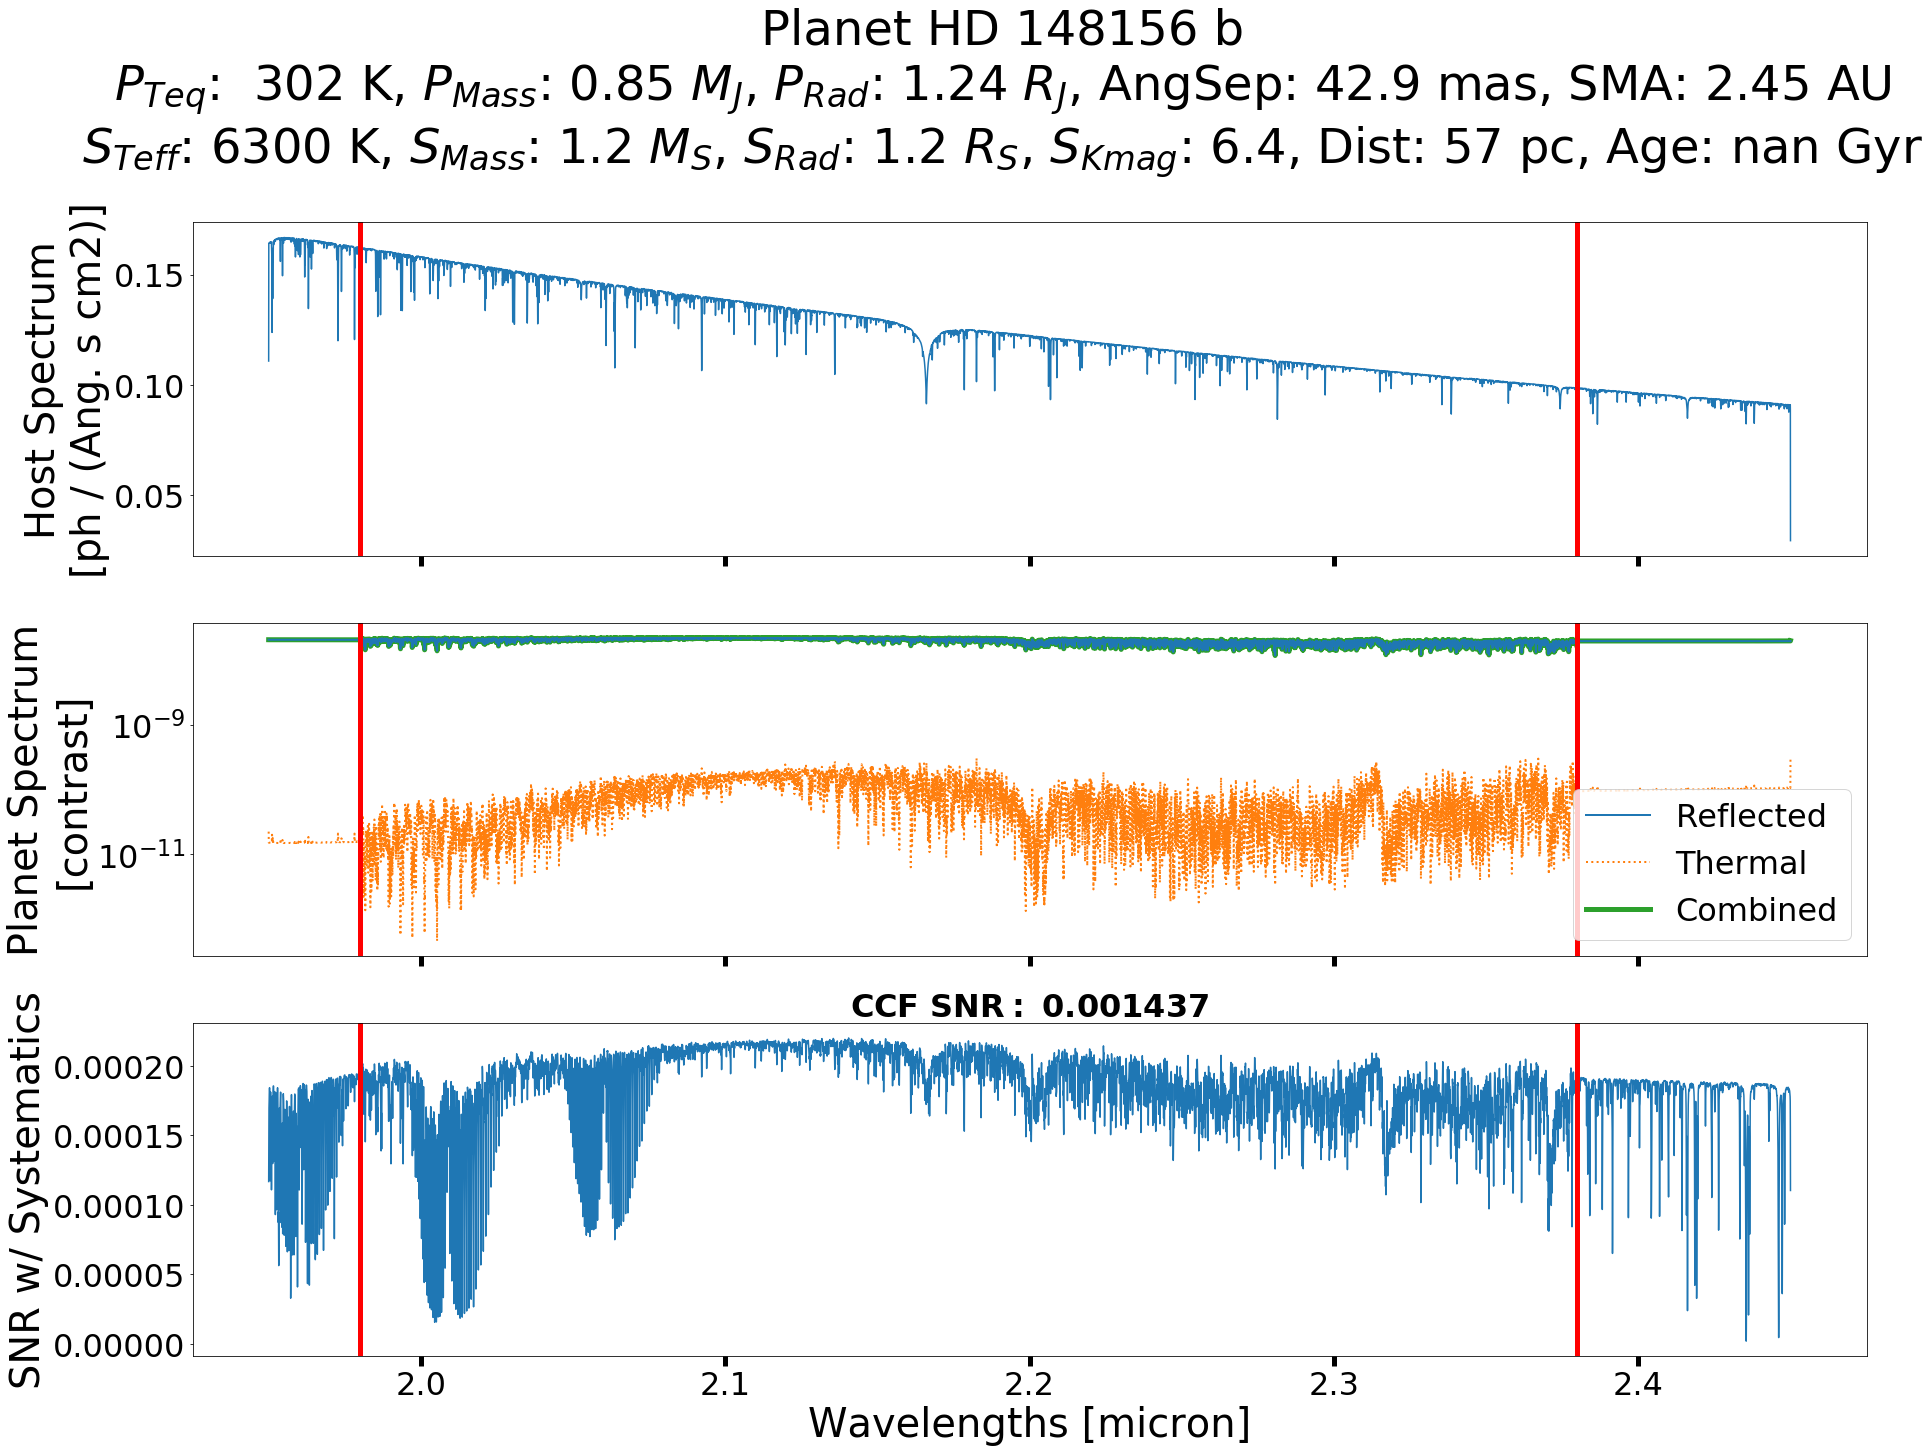

##########################################
  STARTING NEW PLANET
              -------
Planet Name: HD 187085 b
              -------
======     Values Used     =========      
 PMass:    0.84 M_J   |  PRad:   1.24 R_E  |  PTeq:    323.50 K  |  PLogg:   3.13
 SMA:      2.10 AU    |  AngSep: 45.75 mas
 SMass:    1.19 M_S   |  SRad:   1.27 R_E  |  STeff:  6100.00 K  |  SLogg:   4.50
 SAge:     2.75 Gyr   |  SKmag:  5.88      |  SRadV:  15.38 km/s |  SVsini:  5.100
 StarZ:    -0.0       |  SAlpha:     0.0   |  SLimbD:   0.2      |  SAngDiam: 0.25735 mas
 RA:      297.39 deg  |  Dec:   -37.78 deg |  Dist:   45.90 pc

======     Orig Values     =========      
                      |                    |  PTeq:       nan K
                      |                    |  STeff:  6117.00 K  |  SLogg:   4.28
                      |                    |  SRadV:  15.38 km/s |  SVsini:  5.10
 StarZ:   0.120       |                    |

-- Generating Planet spectrum
Spectrum took 9.693 s
-- Dealing

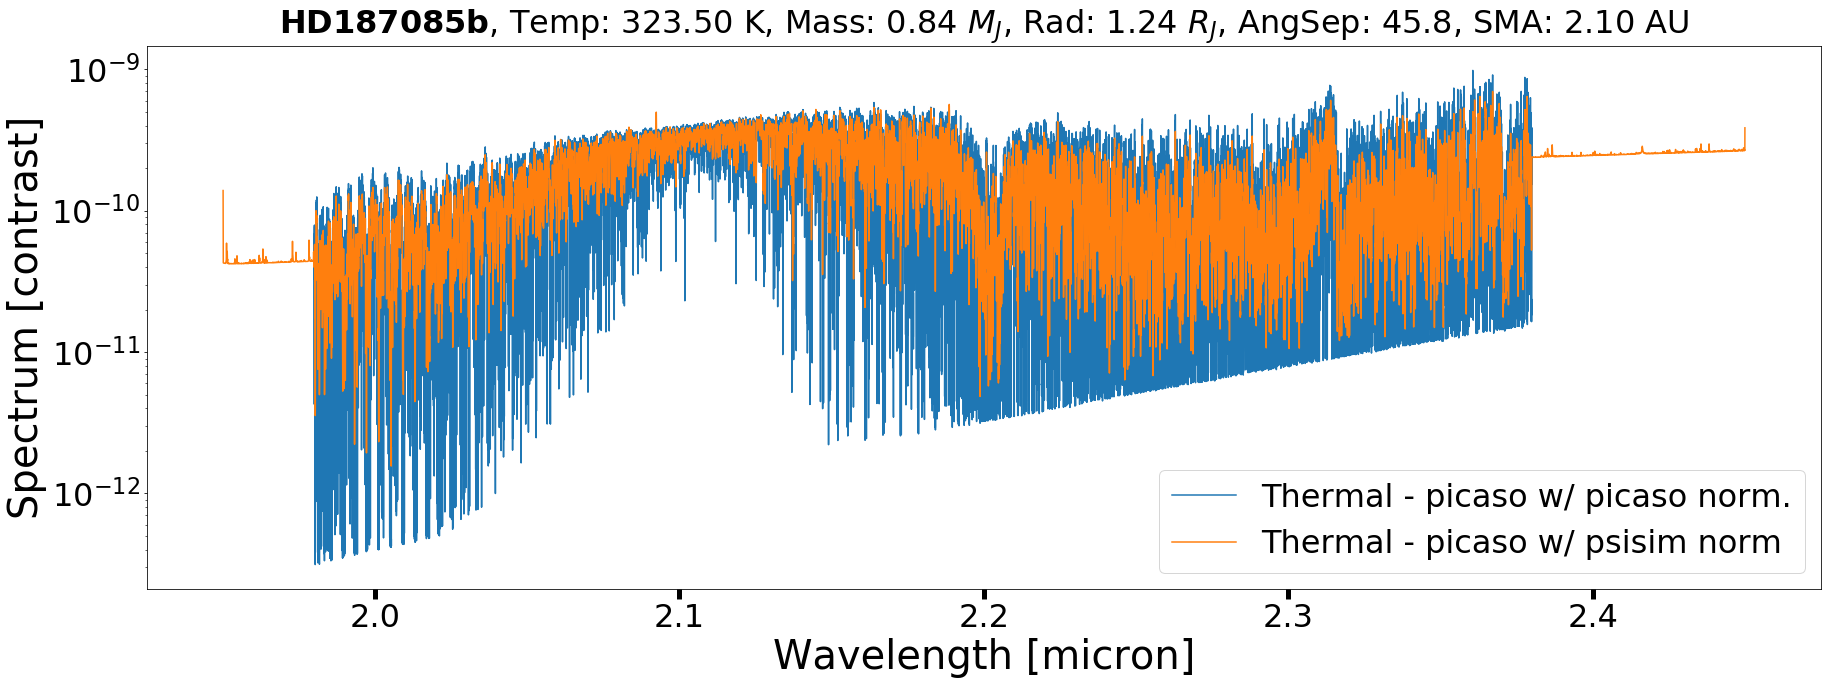

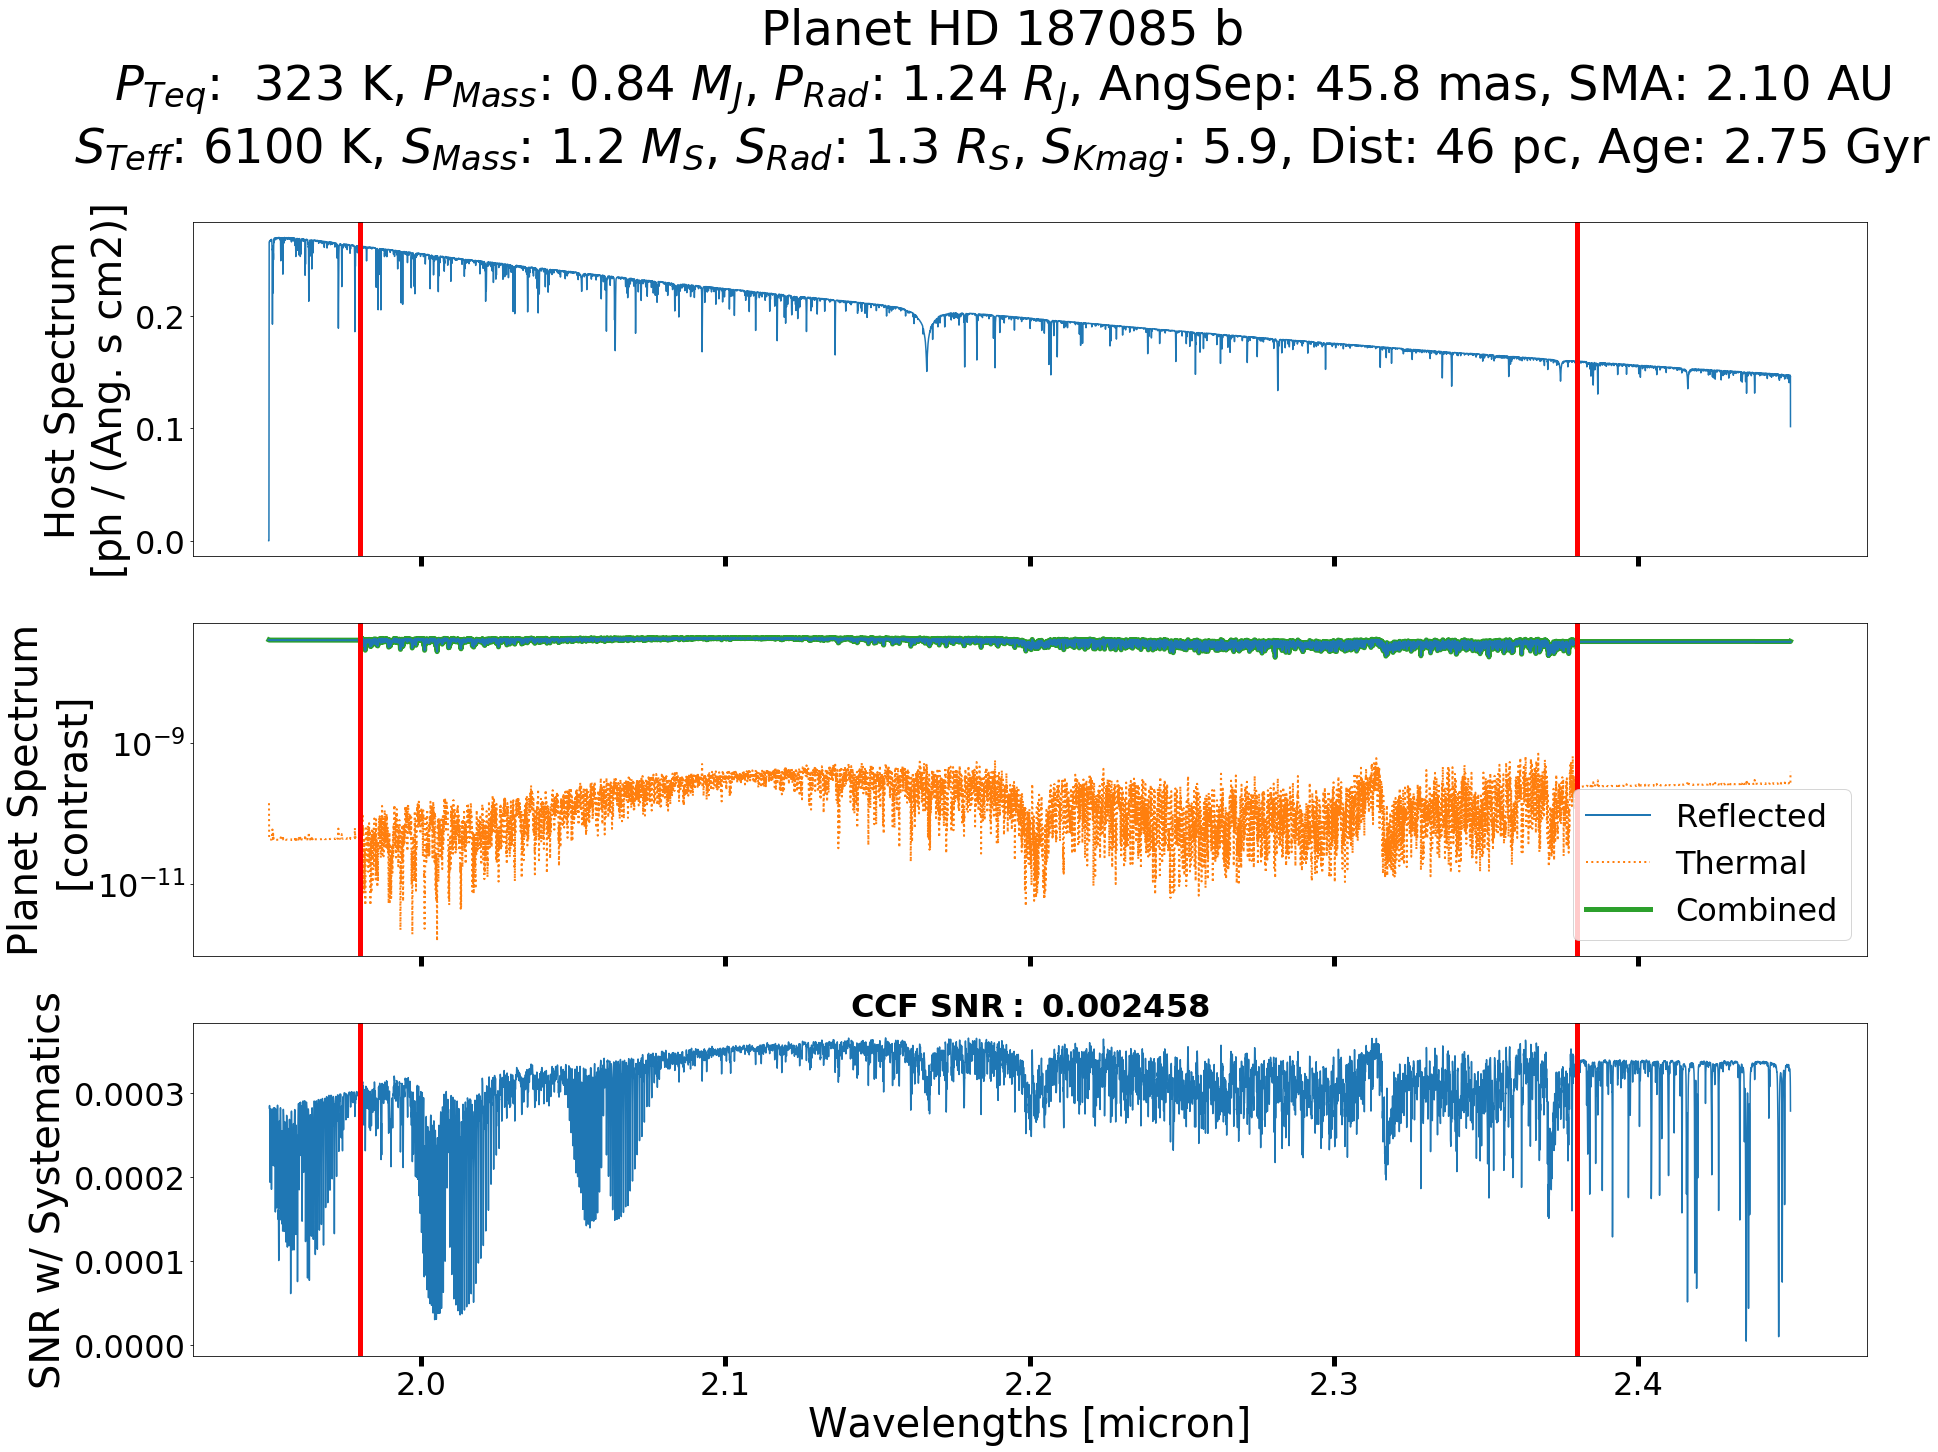

In [16]:
#-- Do some stuff that only needs to happen once, outside of the loop

#Compute sky transmission lines convolved with line spread function
#Get the wavelength spacing
dwvs = np.abs(wavelengths - np.roll(wavelengths, 1))
dwvs[0] = dwvs[1]
dwv_mean = np.mean(dwvs)
lsf_fwhm = (kpic.lsf_width/dwv_mean).decompose() #Get the lsf_fwhm in units of current wavelength spacing
lsf_sigma = lsf_fwhm/(2*np.sqrt(2*np.log(2))) #Convert to sigma
#Get sky transmission lsf
sky_transmission_lsf = gaussian_filter(keck.get_atmospheric_transmission(wavelengths),lsf_sigma.value)

#Get wavelength bounds of valid region for spectra
# index of shortest overlapping wavelength
wv_min_ind = np.argmin(np.abs(opacity.wave.min()-wavelengths.value))+1
# index of longest overlapping wavelength
wv_max_ind = np.argmin(np.abs(opacity.wave.max()-wavelengths.value))-1


### OPTIONAL: 
# Make plots if desired
make_plots = True
# Display simulation properties if desired
print_prop = True


for ind,planet in enumerate(planet_table):
    print('##########################################')
    print('  STARTING NEW PLANET')
    
    if print_prop:
        # Print the system properties for reference
        prop_print(planet, planet_table_raw[ind])
        
    print('-- Generating Planet spectrum')
    # Let's use picaso to generate a spectrum for the planet
    fpfs_ref, fp_therm, df = generate_spectrum(planet)
    
    print('-- Dealing with host spectrum and normalization')
    # We need to pull pull the host spectrum using phoenix
    # aslo need to convert the picaso spectrum to contrast units using our host spec
    fpfs_therm, host_spec, starAOmag = picaso2contrast(planet,fp_therm)
    planet['StarAOmag'] = starAOmag[0][0]
    
    print('-- Runing Simulation!')    
    # Set host diameter for VFN mode
    kpic.set_vfn_host_diameter(planet['StarAngDiam'])
    kpic.ao_mag = planet['StarAOmag']


    #--- Pick the spectrum that has the lowest average contrast
    # Use masking to remove invalid values (nanss and infs and such) so we can compute a valid mean
    #specs = [np.ma.masked_invalid(fpfs_ref).mean(), np.ma.masked_invalid(fpfs_therm).mean()]
    #if np.argmax(specs):
    #    print('Thermal spectrum is more favorable, using that')
    #    planet_spec = fpfs_therm
    #else:
    #    print('Reflected spectrum is more favorable, using that')
    #    planet_spec = fpfs_ref
    #--- Combine the two spectra to look at reflected and thermal light (full planet spectrum)
    print('Using combined (reflected+thermal) spectrum for planet')
    planet_spec = fpfs_therm + fpfs_ref
    meanFR = np.ma.masked_invalid(planet_spec).mean()
    print('Average Flux Ratio: %0.2e'%meanFR)
    planet['Flux Ratio'] = meanFR
    
    #-- Simulate a regular observation
    obj_spec,total_noise,stellar_spec,thermal_spec,noise_components = observation.simulate_observation(keck,kpic,planet,
                                                                                          planet_spec,wavelengths,1e5,
                                                                                          inject_noise=False,verbose=True,
                                                                                          post_processing_gain = np.inf,
                                                                                          return_noise_components=True,
                                                                                          stellar_spec=host_spec,
                                                                                          apply_lsf=True,
                                                                                          integrate_delta_wv=False, 
                                                                                          plot=False,
                                                                                          sky_on=True)

    #-- Simulate observation without sky effects
    obj_spec_no_sky,_,_,_ = observation.simulate_observation(keck,kpic,
                                                                                          planet,
                                                                                          planet_spec,wavelengths,1e5,
                                                                                          inject_noise=False,verbose=True,
                                                                                          post_processing_gain = np.inf,
                                                                                          return_noise_components=False,
                                                                                          stellar_spec=host_spec,
                                                                                          apply_lsf=True,
                                                                                          integrate_delta_wv=False,
                                                                                          plot=False,
                                                                                          sky_on=False)

    #-- Get speckle noise
    speckle_noise = kpic.get_speckle_noise(planet['AngSep'].to(u.arcsec),planet['StarAOmag'],kpic.current_filter,wavelengths,planet['StarSpT'],keck)[0]
    print('Average Contrast: %f'%np.mean(speckle_noise))

    #-- Compute Systematics
    #The photon flux at the object will be the stellar flux multipled by the contrast there:
    host_flux_at_obj = stellar_spec*speckle_noise

    systematics = (cal*(host_flux_at_obj+thermal_spec))**2 #Variance of systematics

    noise_plus_systematics = np.sqrt(total_noise**2+systematics)

    #-- Calculate CCF SNR
    #Crop pertinent spectra so that CCF is only done over region that is well defined for all spectra    
    obj_spec2 = obj_spec[wv_min_ind:wv_max_ind]
    obj_spec_no_sky2 = obj_spec_no_sky[wv_min_ind:wv_max_ind]
    noise_plus_systematics2 = noise_plus_systematics[wv_min_ind:wv_max_ind]
    sky_transmission_lsf2 = sky_transmission_lsf[wv_min_ind:wv_max_ind]
    
    #Get CCF SNR
    ccf_snr = signal.compute_ccf_snr_matchedfilter(obj_spec2, obj_spec_no_sky2, noise_plus_systematics2, 
                                                   sky_transmission_lsf2,
                                                   systematics_residuals=cal, 
                                                   norm_cutoff=0.8)
    print('CCF SNR: %f'%ccf_snr.value)
    print()
    
    if make_plots:
        ## ---- TEMPORARY, WHILE CONFIRMING ACCURACY OF THINGS:
          # Plot our fpfs_thermal vs. picaso's
        plt.figure(figsize=(30,10))
        plt.semilogy(1/df['wavenumber'] * 1e4,df['fpfs_thermal'],label="Thermal - picaso w/ picaso norm.")
        plt.semilogy(wavelengths,fpfs_therm,label="Thermal - picaso w/ psisim norm")
        plt.xlabel("Wavelength [{}]".format(wavelengths.unit))
        plt.ylabel("Spectrum [contrast]")
        plt.title(r"$\bf{%s}$, Temp: %.2f K, Mass: %.2f $M_J$, Rad: %.2f $R_J$, AngSep: %.1f, SMA: %0.2f AU"%(planet['PlanetName'],
                    planet['PlanetTeq'].value, planet['PlanetMass'].to(u.jupiterMass).value,
                    planet['PlanetRadius'].to(u.jupiterRad).value, planet['AngSep'].value,
                    planet['SMA'].value))
        plt.legend()
        ## ---- TEMPORARY, WHILE CONFIRMING ACCURACY OF THINGS:
        res_plotter()
        
        plt.show()